## 章節 6：決策分析（Dicision Analysis）

### 6.7 分佈更新

Player 類別提供 MakeBeliefs 方法，在看到參賽者的 guess 之後，計算後驗分佈。

其中有用到 PmfPrice 方法產生一個近似版本的真實價格分佈，我們用此作為先驗分佈。

In [34]:
from thinkbayes import Suite, EstimatedPdf, MakeCdfFromList, GaussianPdf, Pmf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


class Player(object):
    
    n = 101 # 取樣點數
    price_xs = np.linspace(0, 75000, n) # 價格範圍
    
    def __init__(self, prices, bids, diffs):
        # prices: 真實價格的序列
        # bids: 參賽者出價的序列
        # diffs: 價差的序列
        
        # 平滑化版本的真實價格分佈(先驗分佈)
        self.pdf_price = EstimatedPdf(prices)
        
        # diff 的累積機率分佈，如上圖的 CDF
        self.cdf_diff = MakeCdfFromList(diffs)
        
        mu = 0
        sigma = np.std(diffs)
        
        # 價差的高斯分佈（似然性）
        self.pdf_error = GaussianPdf(mu, sigma)
    
    
    def MakeBeliefs(self, guess):
        pmf = self.PmfPrice() # 產生價格的近似分佈
        self.prior = Price(pmf, self) # 價格先驗分佈
        self.posterior = self.prior.Copy() # 複製價格先驗分佈
        self.posterior.Update(guess) # 更新分佈
        
        
    def PmfPrice(self): # 價格的近似分佈
        return self.pdf_price.MakePmf(self.price_xs)
    
    
    def ErrorDensity(self, error):
        return self.pdf_error.Density(error) # 計算 error 的機率密度


class Price(Suite):
    
    def __init__(self, pmf, player):
        # pmf：先驗分佈
        # player：player 物件
        super().__init__(pmf)
        self.player = player 
        
    def Likelihood(self, data, hypo):
        price = hypo # 假設展示品的真實價格為 price
        guess = data # 參賽者在給定 price 下最好的出價價格
        error = price - guess
        like  = self.player.ErrorDensity(error) # 似然性計算
        return like

    
def plot_pmf(pmf):
    x, y = zip(*sorted(pmf.Items()))
    plt.plot(x, y)


def simple_read_col(file, col_name):
    df = pd.read_csv(file, index_col=0).T
    return df[col_name].astype(int).values

    
def simple_read_prices(file, showcase=1):
    col_name = "Showcase %d" % showcase        
    return simple_read_col(file, col_name)


def get_all_prices(showcase=1): # 先不考慮效率
    data = ["showcases.2011.csv", "showcases.2012.csv"]
    return np.concatenate([simple_read_prices(file, showcase) for file in data])


def simple_read_diff(file, showcase=1):
    col_name = "Difference %d" % showcase        
    return simple_read_col(file, col_name)
    
    
def get_all_diff(showcase=1): # 先不考慮效率
    data = ["showcases.2011.csv", "showcases.2012.csv"]
    return np.concatenate([simple_read_diff(file, showcase) for file in data])


def simple_read_bid(file, showcase=1):
    col_name = "Bid %d" % showcase        
    return simple_read_col(file, col_name)
    
    
def get_all_bid(showcase=1): # 先不考慮效率
    data = ["showcases.2011.csv", "showcases.2012.csv"]
    return np.concatenate([simple_read_bid(file, showcase) for file in data])


def make_pmf(data):
    pdf = EstimatedPdf(data)
    low, high = -30000, 50000
    n = 1001
    xs = np.linspace(low, high, n)
    pmf = pdf.MakePmf(xs)
    return pmf


def plot_kde_prices(showcase=1):
    prices = get_all_prices(showcase)
    print("展示品", showcase, "價格總數", prices.size, "比")
    pdf = EstimatedPdf(prices)

    low, high = 0, 75000
    n = 101
    xs = np.linspace(low, high, n)
    pmf = pdf.MakePmf(xs)
    plot_pmf(pmf)

要建立後驗分佈，我們先複製先驗分佈並且呼叫 Update 方法，此方法會對每個假設的價格呼叫 Price.Likelihood 方法得到似然性，乘上先驗機率，最後做正規化。

我們回到原本的情境。如果你是參賽者 1 並且當你看到展示品後，當下你認為最好的猜測是 20000 美元。

下圖顯示對於價格的先驗分佈和後驗分佈。後驗分佈因為你的猜測在先驗偏低的範圍，所以往左邊偏移。

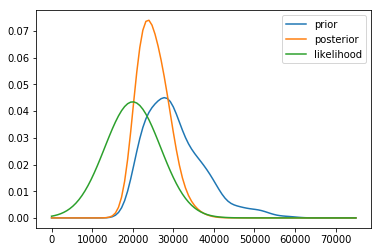

先驗分佈最大機率的價格： 27750.0
後驗分佈最大機率的價格： 24000.0
後驗分佈的期望值： 25096.411816206233


In [49]:
p1_data = [get_all_prices(1), get_all_bid(1), get_all_diff(1)]
player1 = Player(*p1_data)
p1_guess = 20000
player1.MakeBeliefs(p1_guess)


plot_pmf(player1.prior)
plot_pmf(player1.posterior)

# 產生似然性的高斯分佈
likelihood_pmf = Pmf()
for hypo, _ in player1.prior.Items():
    likelihood_pmf.Set(hypo, player1.prior.Likelihood(p1_guess, hypo))
    
likelihood_pmf.Normalize()
plot_pmf(likelihood_pmf)
plt.legend(["prior", "posterior", "likelihood"])
plt.show()

print("先驗分佈最大機率的價格：", player1.prior.MaximumLikelihood())
print("後驗分佈最大機率的價格：", player1.posterior.MaximumLikelihood())
print("後驗分佈的期望值：", player1.posterior.Mean())

在某一層面上，這個結果是有道理的。先驗分佈中最大可能性的價格為 27750 美元，而你覺得最好的猜測是 20000 美元，而後驗分佈的期望值約為 25096 美元。

在另一層面上，你可能會覺得這個結果很奇怪，因為這個後驗分佈建議你，**如果你猜測為 20000 美元，那你應該應該要相信真實價格為 24000 美元**。

為了要解決這個明顯的矛盾，請記得你用了兩種歷史資訊來源：

1. 展示品的真實價格
2. 參賽者猜測的價格

我們用過去的資料當作先驗，並且用你的猜測(guess)更新分佈。

但我們也可以用你的猜測當作先驗，並基於過去的資料來更新分佈。

如果你用這個方式思考，或許你不會太驚訝於後驗分佈的最大可能性的價格並不是你當初猜測的價格。